<a href="https://colab.research.google.com/github/samarthk1206/Financial-Fraud-Detection-Using-GNN/blob/main/FoDS_Grp25_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric optuna xgboost scikit-learn

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, BatchNorm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import gc
import kagglehub
import os

import optuna
import pandas as pd
import numpy as np

import optuna.visualization

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Importing dataset directly from kaggle as opposed to using from google drive
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/paysim1


In [ ]:
csv_path = os.path.join(path, "PS_20174392719_1491204439457_log.csv")
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
# this code was added as a possible solution for the problem RunTime: CUDA out of memory
torch.cuda.empty_cache()
gc.collect()

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
# number of unique values
unique_orig = df['nameOrig'].nunique()
unique_dest = df['nameDest'].nunique()

print(f" Unique values in 'nameOrig': {unique_orig}")
print(f" Unique values in 'nameDest': {unique_dest}")
print(f" Total records: {len(df)}")

 Unique values in 'nameOrig': 6353307
 Unique values in 'nameDest': 2722362
 Total records: 6362620


In [ ]:
# Noticed high cardinality of nameOrig and nameDest so need to do further analysis
# Next steps:
# 1. Do data analysis by using PCA to see what features are of importance
# 2. Remove less important features as shown by PCA

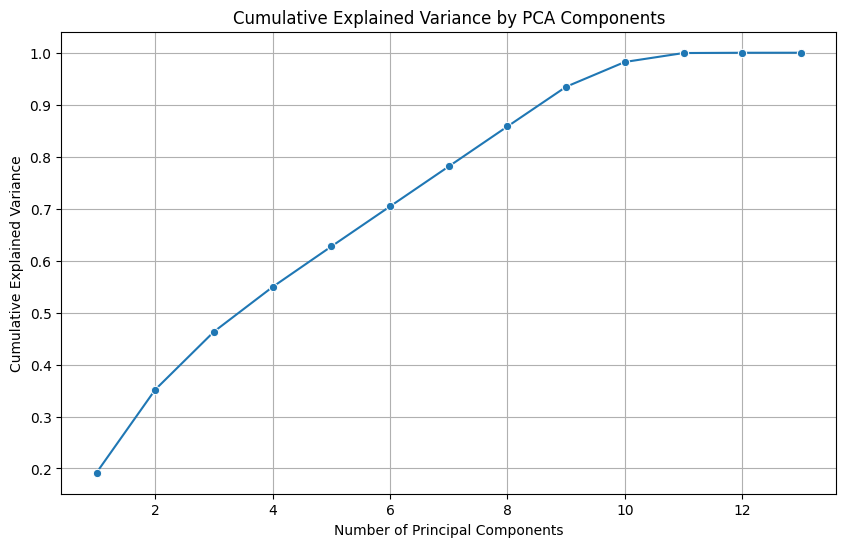


Average Contribution of Features to Top 5 PCA Components:
nameDest          0.002672
nameOrig          0.011779
isFlaggedFraud    0.019060
step              0.062852
newbalanceOrig    0.182082
oldbalanceOrg     0.183072
type_DEBIT        0.212609
amount            0.218986
oldbalanceDest    0.229167
newbalanceDest    0.232839
type_CASH_OUT     0.234427
type_TRANSFER     0.281618
type_PAYMENT      0.285359
dtype: float64

Suggested for removal (based on low PCA contribution):
['nameDest', 'nameOrig', 'isFlaggedFraud', 'step']


In [ ]:

df_encoded = df.copy()

#One-hot encoding the "type" column
df_encoded = pd.get_dummies(df_encoded, columns=['type'], drop_first=True)

# Hash the account names to numeric values for processing
# Using modulo 10^6 to keep values manageable - might have to change this later

df_encoded['nameOrig'] = df_encoded['nameOrig'].apply(lambda x: hash(x) % (10 ** 6))
df_encoded['nameDest'] = df_encoded['nameDest'].apply(lambda x: hash(x) % (10 ** 6))

X = df_encoded.drop(['isFraud'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_)+1),
             y=pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

components_df = pd.DataFrame(pca.components_, columns=X.columns)
abs_components = components_df.abs()  # take absolute value for contribution strength

mean_contrib = abs_components[:5].mean().sort_values()

print("\nAverage Contribution of Features to Top 5 PCA Components:")
print(mean_contrib)

least_important = mean_contrib[mean_contrib < 0.1]  # threshold can be adjusted
print("\nSuggested for removal (based on low PCA contribution):")
print(least_important.index.tolist())

Feature contributions to the first principal component:

          Feature  PCA_Contribution_PC1
4  newbalanceOrig              0.423506
3   oldbalanceOrg              0.421346
7  newbalanceDest              0.411495
6  oldbalanceDest              0.411236
5        nameDest              0.358652
9        type_enc              0.358355
1          amount              0.217983
0            step              0.009501
8  isFlaggedFraud              0.003216
2        nameOrig              0.000202


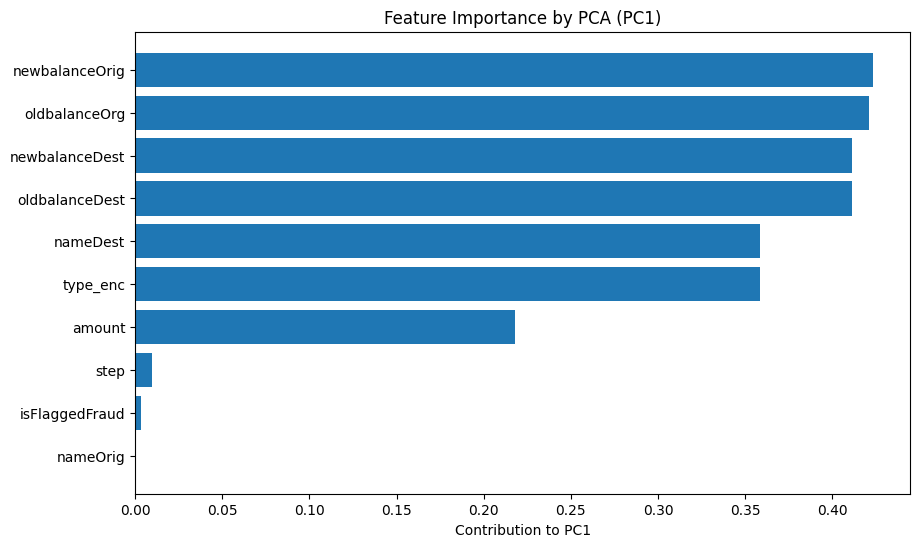

In [ ]:
#Trying a different encoding appraoch to cross verify our results. Using label encoder instead of one-hot

df['type_enc'] = df['type'].astype('category').cat.codes

df_pca = df.copy()

features = df_pca.drop(['isFraud'], axis=1)

#Convert string to category codes
for col in ['nameOrig', 'nameDest']:
    features[col] = features[col].astype('category').cat.codes

features = features.drop(['type'], axis=1) #Dropped orignial type col as we are using encoded version

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

#Run PCA
pca = PCA()
pca_components = pca.fit_transform(scaled_features)

#Created importance df for visualization
importance = pd.DataFrame({
    'Feature': features.columns,
    'PCA_Contribution_PC1': np.abs(pca.components_[0])
}).sort_values(by='PCA_Contribution_PC1', ascending=False)

print("Feature contributions to the first principal component:\n")
print(importance)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['PCA_Contribution_PC1'])
plt.xlabel("Contribution to PC1")
plt.title("Feature Importance by PCA (PC1)")
plt.gca().invert_yaxis() #Put highest value at top
plt.show()


In [ ]:
# Next steps -
# 1. Remove low-importance features
# 2. Do optuna for hyperparameter tuning

In [ ]:
df = df.sample(frac=0.3, random_state=42) #Needed to use a fraction of dataset due to hardware limitations of google colab. Tried using different runtime environments (T4 GPU, v2-8 TPU)

In [ ]:

df = df.reset_index(drop=True)

df['type'] = LabelEncoder().fit_transform(df['type'])

df['nameDest_id'] = LabelEncoder().fit_transform(df['nameDest'])

feature_cols = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

#Converting to pytorch tensors
X = torch.tensor(df[feature_cols].values, dtype=torch.float)
y = torch.tensor(df['isFraud'].values, dtype=torch.long)

#---Graph Construction ---
num_txn = len(df)
unique_dests = df['nameDest_id'].nunique()
total_nodes = num_txn + unique_dests

#Initialse node features
x_all = torch.zeros((total_nodes, X.shape[1]))
x_all[:num_txn] = X

## Create edge connections between transactions and destination accounts
txn_indices = df.index.values
dest_indices = df['nameDest_id'].values + num_txn #Offset to void overlap
edge_index = torch.tensor([txn_indices, dest_indices], dtype=torch.long)

all_txn_indices = np.arange(num_txn)
train_idx, test_idx = train_test_split(all_txn_indices, test_size=0.2, random_state=42, stratify=y.numpy())

#Creating masks for training and testing
train_mask = torch.zeros(total_nodes, dtype=torch.bool)
test_mask = torch.zeros(total_nodes, dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

# Created labels for all nodes (-1 for unlabeled nodes like destination accounts)
final_y = torch.full((total_nodes,), -1, dtype=torch.long)  # -1 for unlabeled
final_y[:num_txn] = y

# Creating PyTorch Geometric Data object
data = Data(x=x_all, edge_index=edge_index, y=final_y, train_mask=train_mask, test_mask=test_mask)

print(data)
print(f"Train mask sum: {train_mask.sum()}, Test mask sum: {test_mask.sum()}")
print(f"Total nodes: {total_nodes}, Num txn: {num_txn}, Unique dest nodes: {unique_dests}")

<ipython-input-23-3b98538106dc>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([txn_indices, dest_indices], dtype=torch.long)


Data(x=[2964066, 6], edge_index=[2, 1908786], y=[2964066], train_mask=[2964066], test_mask=[2964066])
Train mask sum: 1527028, Test mask sum: 381758
Total nodes: 2964066, Num txn: 1908786, Unique dest nodes: 1055280


In [ ]:
# import torch
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from torch_geometric.data import Data

# # Sample the dataset (assumes df is already loaded)
# df_sampled = df.sample(frac=1, random_state=42)

# # Encode 'type' and 'nameOrig' using LabelEncoder (still useful for type/category)
# for col in ['type', 'nameOrig']:
#     df[col] = LabelEncoder().fit_transform(df[col])

# # Apply hash encoding to 'nameDest'
# df['nameDest'] = pd.util.hash_pandas_object(df['nameDest'], index=False).astype('int64') % (10**6)
# # Note: hash mod value (e.g., 10^6) prevents extremely large int values, tweak based on memory constraints

# # Drop unwanted columns
# df = df.drop(['nameOrig', 'step', 'isFlaggedFraud'], axis=1)

# # Feature scaling
# features_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'nameDest']
# scaler = StandardScaler()
# df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# # Prepare feature matrix and labels
# X = torch.tensor(df.drop('isFraud', axis=1).values, dtype=torch.float)
# y = torch.tensor(df['isFraud'].values, dtype=torch.long)

# # Construct edge_index using nameDest as sender and (type + amount) hash as receiver
# senders = df['nameDest'].values

# # Generate receiver hash (composite of 'type' and 'amount')
# receivers_hash = pd.util.hash_pandas_object(
#     df['type'].astype(str) + "_" + df['amount'].astype(str), index=False
# ).astype('int64') % (10**6)

# receivers = receivers_hash.values

# # Create edge_index [2, num_edges]
# edge_index = torch.tensor([senders, receivers], dtype=torch.long)

# # Construct graph
# data = Data(x=X, edge_index=edge_index, y=y)

# # Train/test split
# train_idx, test_idx = train_test_split(range(len(data.y)), test_size=0.2, random_state=42)

# # Create train/test masks
# train_mask = torch.zeros(len(data.y), dtype=torch.bool)
# test_mask = torch.zeros(len(data.y), dtype=torch.bool)
# train_mask[train_idx] = 1
# test_mask[test_idx] = 1

# # Add masks to data object
# data.train_mask = train_mask
# data.test_mask = test_mask

# # Output basic graph info
# print(data)


In [ ]:
#GCN Model Definition
class GCNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.3):
        super(GCNClassifier, self).__init__()
        assert num_layers >= 2, "Number of layers must be at least 2"

        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))

        #Adding intermediate layers if requested
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout #for regulatiosation

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, edge_index)
        return x


In [ ]:
def objective_gcn(trial):
    # hyperparameter search space
    hidden_dim = trial.suggest_int("hidden_dim", 16, 64, step=16)
    dropout = trial.suggest_float("dropout", 0.3, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    num_layers = trial.suggest_int("num_layers", 2, 5)
    epochs = trial.suggest_int("epochs", 10, 50, step=10)

    #creating model with trial hyperparameters
    model = GCNClassifier(
        in_channels=data.x.shape[1],
        hidden_channels=hidden_dim,
        out_channels=2, #bnary classification - Fraud or not
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x.to(device), data.edge_index.to(device))
        loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out = model(data.x.to(device), data.edge_index.to(device))
        pred = out[data.test_mask].argmax(dim=1)
        acc = accuracy_score(data.y[data.test_mask].cpu(), pred.cpu())

    return acc

In [ ]:
def objective_ml(trial):
    #choose amongst these baseline ML models
    model_name = trial.suggest_categorical("model", ["DecisionTree", "RandomForest", "XGBoost", "LogisticRegression"])

    X_train = data.x[data.train_mask].numpy()
    y_train = data.y[data.train_mask].numpy()
    X_test = data.x[data.test_mask].numpy()
    y_test = data.y[data.test_mask].numpy()

    if model_name == "DecisionTree":
        max_depth = trial.suggest_int("max_depth", 3, 10)
        clf = DecisionTreeClassifier(max_depth=max_depth, class_weight='balanced')

    elif model_name == "RandomForest":
        n_estimators = trial.suggest_int("n_estimators", 50, 150)
        max_depth = trial.suggest_int("max_depth", 3, 10)
        clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   class_weight='balanced', n_jobs=-1)

    elif model_name == "XGBoost":
        n_estimators = trial.suggest_int("n_estimators", 50, 150)
        max_depth = trial.suggest_int("max_depth", 3, 10)
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
        clf = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,
                          learning_rate=learning_rate, scale_pos_weight=100, #for class imbalance
                          eval_metric='logloss', tree_method='hist', device='cuda')

    else:  # logistic Regression
        C = trial.suggest_float("C", 0.01, 10.0, log=True)
        clf = LogisticRegression(C=C, max_iter=1000, class_weight='balanced')

    # pipeline with automatic naming
    pipeline = make_pipeline(StandardScaler(), clf)

    classifier_step_name = pipeline.steps[-1][0]

    from sklearn.utils import class_weight
    sample_weights = class_weight.compute_sample_weight('balanced', y_train)

    try:
        pipeline.fit(X_train, y_train,
                    **{f'{classifier_step_name}__sample_weight': sample_weights}
                    if model_name != 'XGBoost' else {})
    except ValueError:
        # Fall back to regular fit if sample weights cause issues
        pipeline.fit(X_train, y_train)

    preds = pipeline.predict(X_test)
    acc = accuracy_score(y_test, preds)

    return acc

In [ ]:
print("Optimizing GCN...")
study_gcn = optuna.create_study(direction="maximize")
study_gcn.optimize(objective_gcn, n_trials=10)
print("Best GCN config:", study_gcn.best_params)


[I 2025-04-23 15:34:24,185] A new study created in memory with name: no-name-465b984d-1036-4ce6-9fba-c8e6c26d12ab


Optimizing GCN...


[I 2025-04-23 15:34:31,881] Trial 0 finished with value: 0.9987243227384888 and parameters: {'hidden_dim': 48, 'dropout': 0.3037614746819533, 'lr': 0.0067836237736364135, 'weight_decay': 3.886979599140714e-05, 'num_layers': 4, 'epochs': 10}. Best is trial 0 with value: 0.9987243227384888.
[I 2025-04-23 15:34:43,681] Trial 1 finished with value: 0.9987243227384888 and parameters: {'hidden_dim': 64, 'dropout': 0.3140638257854517, 'lr': 0.0014870917155303104, 'weight_decay': 9.255175801959641e-05, 'num_layers': 4, 'epochs': 20}. Best is trial 0 with value: 0.9987243227384888.
[I 2025-04-23 15:34:54,549] Trial 2 finished with value: 0.9987243227384888 and parameters: {'hidden_dim': 16, 'dropout': 0.44438852255916883, 'lr': 0.0032296837993577884, 'weight_decay': 0.00011079451938832102, 'num_layers': 4, 'epochs': 40}. Best is trial 0 with value: 0.9987243227384888.
[I 2025-04-23 15:35:12,674] Trial 3 finished with value: 0.9987243227384888 and parameters: {'hidden_dim': 48, 'dropout': 0.3121

Best GCN config: {'hidden_dim': 64, 'dropout': 0.30821893485064505, 'lr': 0.0005024108853733904, 'weight_decay': 0.0002816954228593236, 'num_layers': 4, 'epochs': 10}


In [ ]:
#Visualisation GCN optimization results
optuna.visualization.plot_param_importances(study_gcn)
optuna.visualization.plot_slice(study_gcn)
optuna.visualization.plot_optimization_history(study_gcn)

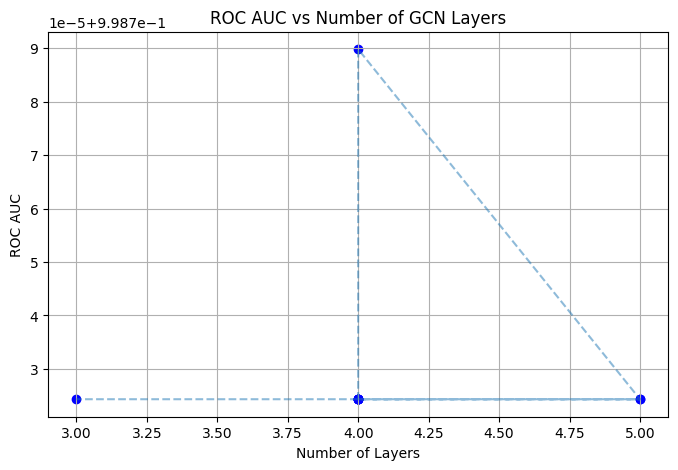

In [ ]:
# Plot relationship between layers and performance
layers = [trial.params["num_layers"] for trial in study_gcn.trials if trial.value is not None]
scores = [trial.value for trial in study_gcn.trials if trial.value is not None]

plt.figure(figsize=(8, 5))
plt.scatter(layers, scores, c='blue')
plt.plot(layers, scores, linestyle='dashed', alpha=0.5)
plt.xlabel("Number of Layers")
plt.ylabel("ROC AUC")
plt.title("ROC AUC vs Number of GCN Layers")
plt.grid(True)
plt.show()

In [ ]:
# best trial info
print("Best GCN Accuracy:", study_gcn.best_value)
print("Best Trial Parameters:", study_gcn.best_trial.params)

Best GCN Accuracy: 0.9987898092508867
Best Trial Parameters: {'hidden_dim': 64, 'dropout': 0.30821893485064505, 'lr': 0.0005024108853733904, 'weight_decay': 0.0002816954228593236, 'num_layers': 4, 'epochs': 10}


In [ ]:
optuna.visualization.plot_optimization_history(study_gcn).show()
optuna.visualization.plot_param_importances(study_gcn).show()

optuna.visualization.plot_param_importances(study_gcn)
optuna.visualization.plot_slice(study_gcn, params=['num_layers'])

In [ ]:
print("Optimizing ML models...")
study_ml = optuna.create_study(direction="maximize")
study_ml.optimize(objective_ml, n_trials=200)
print("Best ML model:", study_ml.best_params)

[I 2025-04-23 15:36:17,478] A new study created in memory with name: no-name-cc1214ce-0d45-434c-8d73-3afeb27c4295


🔍 Optimizing ML models...


[I 2025-04-23 15:36:25,377] Trial 0 finished with value: 0.9411695367222167 and parameters: {'model': 'DecisionTree', 'max_depth': 9}. Best is trial 0 with value: 0.9411695367222167.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[15:36:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.


[I 2025-04-23 15:36:28,994] Trial 1 finished with value: 0.9993137013500699 and parameters: {'model': 'XGBoost', 'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.2854251909032672}. Best is trial 1 with value: 0.9993137013500699.
[I 2025-04-23 15:36:32,205] Trial 2 finished with value: 0

KeyboardInterrupt: 

In [ ]:
print("Best ML Accuracy:", study_ml.best_value)
print("Best ML Model:", study_ml.best_trial.params)
print("Best GCN Config:", study_gcn.best_trial.params)

Best ML Accuracy: 0.9994577716773453
Best ML Model: {'model': 'XGBoost', 'n_estimators': 141, 'max_depth': 10, 'learning_rate': 0.29885727428916686}
Best GCN Config: {'hidden_dim': 64, 'dropout': 0.30821893485064505, 'lr': 0.0005024108853733904, 'weight_decay': 0.0002816954228593236, 'num_layers': 4, 'epochs': 10}


In [ ]:
print("Best GCN Accuracy:", study_gcn.best_value)

Best GCN Accuracy: 0.9987898092508867
